# Machine learning classification of oxidation states in strontium iron oxide based on electron energy loss spectra

Phacharapol Tanasarnsopaporn<sup>1*</sup>, Joshua Agar<sup>1</sup>, James Hart<sup>2</sup>, and Mitra Taheri<sup>3</sup>

<sup>1</sup> Department of Materials Science and Engineering, Lehigh University, USA  
<sup>2</sup> Department of Materials Science and Engineering, Drexel University, USA  
<sup>3</sup> Department of Materials Science and Engineering, John Hopkins University, USA  
\* Correspondent pht219@lehigh.edu

*Updated on December 17, 2019*

## Abstract (text)

Stochiometric evolution in strontium iron oxide is of critical importance to the understanding of process-structure-property relationship of the material. In-situ electron energy loss spectroscopy (EELS) can be used to reveal the changes in oxidation states during the annealing process, whereby the precise spatial information of oxidation transition may be determined. However, observing stochiometric changes in the material at real-time poses challenge due to the large amount of noisy data. Machine learning methods demonstrate promise in both improving signal interpretation and automating precise control of strontium iron oxide synthesis. This paper highlights and compares the use of various deep learning architectures, both supervised and unsupervised, in classifying the oxidation states from temporal EELS data.

## Introduction (text)
Strontium iron oxide, SrFeO<sub>3-δ</sub> or SFO, is a magnetic material commonly known for its high coercivity with applications ranging from DVDs to electric motors [1]. However, a small change in its oxide composition to δ=0.125 brings about a metal-to-insulator transition. This variation causes a large change in resistivity, whereby the reduction and oxidation mechanism of SFO can be utilized in a new generation of transistors [2,3]. At δ=0.25, the crystallographic structure becomes orthorhombic, and this coincides with an antiferromagnetic transition which may find potentials in novel applications such as spintronics or antiferromagnetic memories [4]. From these examples, it becomes apparent that the stoichiometric information of SFO can serve as an efficient tool in tuning the electronic, crystallographic and magnetic states during material processing.

To monitor the stoichiometry of SFO, electron energy loss spectroscopy (EELS) can be utilized. EELS is a high-speed characterization technique that can be used to obtain structural and chemical information about a material by measuring material’s interaction with electron beam. EELS is also a spatially localized technique where the measurement resolutions can be achieved to ~0.1 nm. Therefore, implementing EELS as an in-situ characterization tool during oxidation-reduction or annealing processes can help reveal how various phases of SFO grows in real time. However, determining the chemical composition at nanoscale using EELS can face challenges due to the low signal-to-noise ratio (SNR). While this problem can be mitigated by summing up the signals over a large area or increasing the time of signal collection, high spatial resolution and fast measurement are needed to monitor the evolution of SFO at real time.

From Nvidia’s acoustic suppression to Google’s image recognition [5], machine learning algorithms have proven useful as a noise reduction and classification techniques in various applications. In this paper, we explore the use of machine learning models and deep learning architectures in both supervised and non-supervised manner to classify oxidation states of strontium iron oxide.

## Code Initialization (code)

### Import Packages (code)

In [2]:
%matplotlib inline
import hyperspy.api as hs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import itertools

In [63]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Conv2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed, MaxPooling2D,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam, SGD
from keras.regularizers import l1

Using TensorFlow backend.


## Materials Data (text)
To construct a test dataset, we collected the EELS spectra from an SFO sample under transmission electron microscope (TEM). Ten EELS spectrum images of size 30-by-300 pixels were collected sequentially over the same area. The sample was then ex-situ annealed to drive reduction reaction before additional 10 images were collected to observe the spectral differences. In total, 180,000 spectra were collected with 3710 energy channels, 0.125 eV per channel, and the energy field of view extending from 387.5 eV to 851.25 eV.

<img src="paper_supplement_materials/figure_1.jpg"
     alt="Figure 1"
     style="float: left; margin-right: 10px;"/>  
**Figure 1.** The top image is a dark field image of the cross-sectional structure of the sample. The two lower images show the lattice structure and diffraction pattern of the sample before and after annealing.

High-resolution transmission electron microscopy (HRTEM) was then used to confirm the crystal structure before and after annealing. The analysis shows that the sample contains the perovskite structure before annealing and the orthorhombic structure after annealing. These correspond with the crystal structures of SrFeO3 and SrFeO2.5, respectively. We confirmed this transition by observing the changes in EELS spectrum fingerprint. By averaging individual spectra from the annealed and non-annealed samples, we obtained a high SNR that displayed apparent changes at 525-550 eV and 710-730 eV. These coincide with the oxygen K-edge and ferrite L-edge energy values, thus confirming the change in chemical composition of SFO after annealing. 

<img src="paper_supplement_materials/figure_2.jpg"
     alt="Figure 2"
     style="float: left; margin-right: 10px;"/>  
**Figure 2.** Top two graphs show the individual spectra from each pixel on the EELS image. The high signal-to-noise ratio (bottom) is obtained by averaging the spectra in each EELS image.

### Loading Data (code)

<span style="color:red">**By running this code, you will be downloading spectral files from Google Drive (~2GB). Please run this code with care.** </span>

In [5]:
user_prompt = input("Are you sure you want to download the spectral files from 3rd party Google Drive? (Y/N)")

if user_prompt == "Y":
    # Download files onto remote computer
    import gdown
    url = r'https://drive.google.com/uc?id=1fdKX_de8cMF8zv3yGsJZB7r_igPn8kT8' # binary spectral files
    output = 'temp.zip'
    gdown.download(url, output, quiet=False)
    
    # Unzip files
    import zipfile
    with zipfile.ZipFile('temp.zip', 'r') as zip_ref:
        zip_ref.extractall('temporal_data')
        
    # Remove zip file after extraction
    import os
    os.remove("temp.zip")
    print("File Removed!")
    
else:
    print("Files NOT downloaded.")
    pass

Are you sure you want to download the spectral files from 3rd party Google Drive? (Y/N)n
Files NOT downloaded.


In [6]:
# Loading Initial Data
data_initial = hs.load('temporal_data/High-Speed EELS/Initial SIs/*.dm4', stack=False)
#print(data_initial.metadata)
#print(data_initial.axes_manager)

In [7]:
# Loading Annealed Data
data_anneal = hs.load('temporal_data/High-Speed EELS/annealed SIs/*.dm4', stack=False)
#print(data_anneal.metadata)
#print(data_anneal.axes_manager)

## Preprocessing (text)
Before the collected data can be used to train machine learning models, a number of feature engineering steps was completed to ensure that the data was in a correct format and can be properly utilized. 

### (a) Data Calibration (text)
Due to an issue with the EELS collection software, the data must first be corrected by adding a dark reference spectrum to each individual collected spectrum. By the nature of EELS data, all spectra also have an exponential background noise that can be corrected by performing power-law curve fit.

#### (a.1) Adding dark reference (code)

In [8]:
def add_dark_ref(stacked_data, dark_ref):
    """
    Add dark references to EELS dataset
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)
    dark_ref: 1d array
        dark reference for correction
    """
    dim = stacked_data[0].data.shape
    for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
        stacked_data[k].data[i][j] = np.sum([stacked_data[k].data[i][j],dark_ref.data], axis=0)

In [9]:
# Add dark references
dark_ref = hs.load('temporal_data/High-Speed EELS/dark reference.dm4', signal_type="EELS")
add_dark_ref(data_initial, dark_ref)
add_dark_ref(data_anneal, dark_ref)

#### (a.2) Background Subtraction (code)

Performing background subtraction based on power law fit. $I = A*E^r$ where I is the measured intensity, A is a constant, E is the energy-loss value (eV), and r is an exponent (usually around 3). An energy window selected is around 50 eV wide, a few eV before the region of interest to fit A and r.

> **Resources**
* https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes \
* https://scipy-cookbook.readthedocs.io/items/FittingData.html \
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [10]:
'''
Background Subtraction & Filter noise (Savizky-Golay Filter)
'''
import scipy.optimize # curve_fit
from scipy.fftpack import fft

def scaledExp(x,a,b):
    return a*np.exp((np.array(x))*b)

def subtractExpBackground(data1,xrange=None):
    data2 = np.float32(np.copy(data1))
    x = range(data1.shape[2])
    # fit over the entire spectra by default
    if type(xrange) == type(None):
        xrange = x 
    for i in range(data1.shape[0]):
        for j in range(data1.shape[1]):
            popt, pcov = scipy.optimize.curve_fit(scaledExp,xrange,data2[i,j,xrange], p0 = [4.19082741e+02, -1.93625569e-03])
            data2[i,j] = data2[i,j]-scaledExp(x,popt[0],popt[1])
            # print(popt)
    return data2

def subtract_bckgrnd(data):
    backgroundregion = np.arange(400,1000,1)  # this is approximately 50eV wide, over the region before ROI
    for k,spectra in enumerate(data): 
        data[k].data = subtractExpBackground(spectra.data,backgroundregion)

In [11]:
# subtract background
subtract_bckgrnd(data_initial)
subtract_bckgrnd(data_anneal)

### (b) Reducing random noise (text)(code)
To allow the machine learning models to focus on the trends of the signal, Savitzky–Golay filter was applied to smooth out the local variations in the EELS spectra [6]. 

In [12]:
def filter_savgol(stacked_data):
    """
    Apply Savitzky–Golay filter to reduce noise
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)
    """
    for k,spectra in enumerate(stacked_data):
        # Savitzky–Golay filter with window size 51, polynomial order 3
        stacked_data[k].data = scipy.signal.savgol_filter(stacked_data[k].data, 51, 3) # window size 50, polynomial order 3

In [13]:
# Apply SavGol filter
filter_savgol(data_initial)
filter_savgol(data_anneal)

### (c) Cropping spectral image (text)(code)


(30, 300)


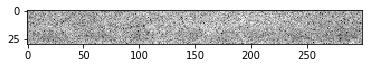

In [14]:
# Visualizing cropped area
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_number = 2

cropped = np.average(data_initial[3].data[:], axis=(2))
print(cropped.shape)

fig, ax = plt.subplots()
im = ax.imshow(cropped)

In [15]:
# window is y = [7:35]
def crop(data):
    for k,sp in enumerate(data):
        data[k].data = sp.data[7:35]
        print(str(k)+": "+str(data[k].data.shape))

In [16]:
#crop(raw_data)

### (d) Down-sampling (text)(code)
Training deep learning models on complex  EELS signals can be computationally expensive. Reducing the number of data points, while maintaining the important features of the spectra, will help to reduce computational requirement and allow faster training time.

> **Resources**
* https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.downscale_local_mean

In [17]:
from scipy.signal import resample

def downsample(stacked_data, N_resampled:int):
    """
    down sampling the data
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    N_resampled: int
        number of samples in the resampled set
    """
    dim = stacked_data[0].data.shape
    if N_resampled != dim[2]: 
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], N_resampled))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = resample(stacked_data[k].data[i][j][:], N_resampled) 
    else:
        for k,sp in enumerate(stacked_data):
            stacked_data[k].resample = np.zeros((dim[0],dim[1], dim[2]))
        for k, i, j in itertools.product(range(len(stacked_data)), range(dim[0]), range(dim[1])):
            stacked_data[k].resample[i][j] = stacked_data[k].data[i][j][:]

In [18]:
data_initial[0].data.shape

(30, 300, 3710)

In [19]:
N_resampled = 1500
#N_resampled = data_initial[0].data.shape[2]

downsample(data_initial, N_resampled)
downsample(data_anneal, N_resampled)

#### Visualize aggregated signals (code)

Visualizing what we would expect from combined signals. This is just a quality assurance that we didn't do something real wrong. Signals should look smooth and pretty when SNR is high!

Text(0, 0.5, 'counts')

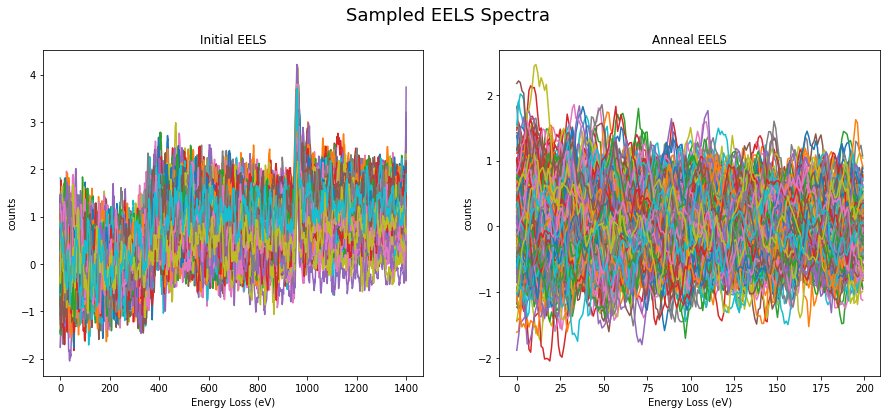

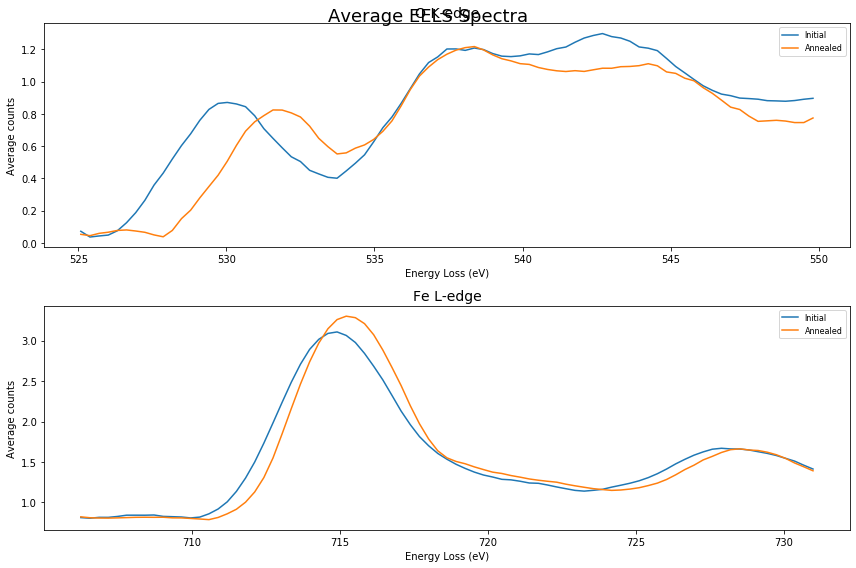

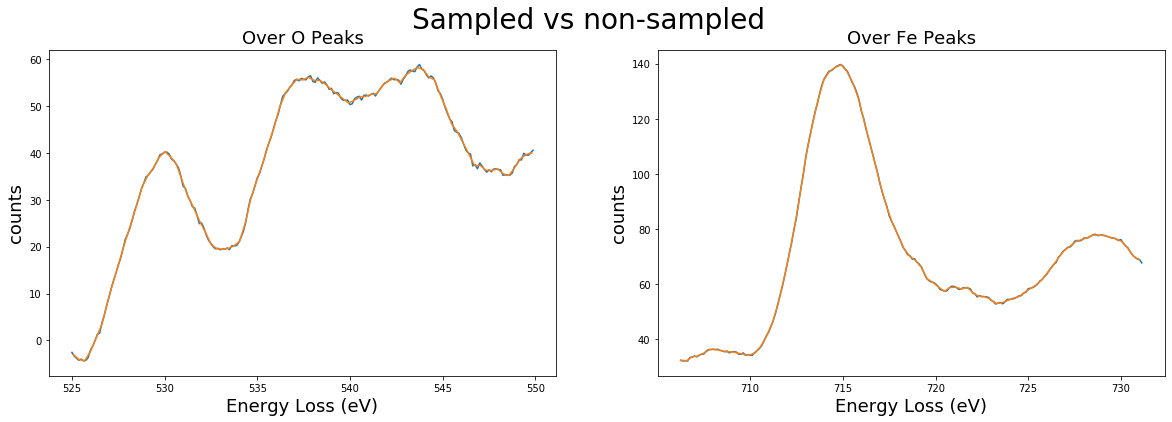

In [23]:
# visualizing raw data

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV
o_r = (1100,1300)
fe_r = (2550,2750)

frac = N_resampled/data_initial[0].data.shape[2]
O_range = range(math.ceil(o_r[0]*frac),math.ceil(o_r[1]*frac),1)
Fe_range = range(math.ceil(fe_r[0]*frac),math.ceil(fe_r[1]*frac),1)
O_xrange = [start+step*i/frac for i in O_range]
Fe_xrange = [start+step*i/frac for i in Fe_range]

# Plotting individual spectrum
f,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
# initial data on image 3, [20,:,400:2500]
for i in data_initial[3].resample[20]:
    ax1.plot(i[100:3000])
# plotting individual anneal data on image 3, [20,:,400:2500]
for i in data_anneal[3].resample[20]:
    ax2.plot(i[100:300])

# Plotting averaged spectra 
g,(ax3,ax4) = plt.subplots(2,1, figsize=(12,8))
# Plotting average over oxygen range
ax3.plot(O_xrange, np.average(data_initial[3].resample[15][100:200], axis=0)[O_range], label="Initial")
ax3.plot(O_xrange, np.average(data_anneal[3].resample[15][100:200], axis=0)[O_range], label="Annealed")
# Plotting average over Fe range
ax4.plot(Fe_xrange, np.average(data_initial[3].resample[15][10:200], axis=0)[Fe_range], label="Initial")
ax4.plot(Fe_xrange, np.average(data_anneal[3].resample[15][10:200], axis=0)[Fe_range], label="Annealed")

# Plotting aggregared spectra (sampled vs non-sampled)
h,(ax5,ax6) = plt.subplots(1,2, figsize=(20,6))
# Plotting aggregation over oxygen range
ax5.plot([start+(i*step) for i in range(o_r[0],o_r[1],1)], np.sum(data_initial[3].data[15][50:100], axis=0)[o_r[0]:o_r[1]])
ax5.plot(O_xrange, np.sum(data_initial[3].resample[15][50:100], axis=0)[O_range])
# Plotting aggregation over Fe range
ax6.plot([start+(i*step) for i in range(fe_r[0],fe_r[1],1)], np.sum(data_initial[3].data[15][50:100], axis=0)[fe_r[0]:fe_r[1]])
ax6.plot(Fe_xrange, np.sum(data_initial[3].resample[15][50:100], axis=0)[Fe_range])

# plot configurations
f.suptitle('Sampled EELS Spectra', fontsize=18)

ax1.set_title('Initial EELS', fontsize=12)
ax1.set_xlabel('Energy Loss (eV)', fontsize=10)
ax1.set_ylabel('counts', fontsize=10)

ax2.set_title('Anneal EELS', fontsize=12)
ax2.set_xlabel('Energy Loss (eV)', fontsize=10)
ax2.set_ylabel('counts', fontsize=10)   

g.suptitle('Average EELS Spectra', fontsize=18)

ax3.set_title('O K-edge', fontsize=14)
ax3.set_xlabel('Energy Loss (eV)', fontsize=10)
ax3.set_ylabel('Average counts', fontsize=10)   
ax3.legend(fontsize=8)

ax4.set_title('Fe L-edge', fontsize=14)
ax4.set_xlabel('Energy Loss (eV)', fontsize=10)
ax4.set_ylabel('Average counts', fontsize=10)   
ax4.legend(fontsize=8)

g.tight_layout()

h.suptitle('Sampled vs non-sampled', fontsize=28)
ax5.set_title('Over O Peaks', fontsize=18)
ax5.set_xlabel('Energy Loss (eV)', fontsize=18)
ax5.set_ylabel('counts', fontsize=18)   

ax6.set_title('Over Fe Peaks', fontsize=18)
ax6.set_xlabel('Energy Loss (eV)', fontsize=18)
ax6.set_ylabel('counts', fontsize=18)   

### (e) Adding identification numbers (text)(code)
Identification numbers are used to identify what data points belong to, anneal vs non-anneal.

In [24]:
def add_target_id(stacked_data, id:int):
    """
    adding target id to data
    
    Parameters
    -----------
    stacked_data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    id: int
        identification for that dataset
    """
    for k,f in enumerate(stacked_data):
        stacked_data[k].target = np.full((f.data.shape[0],f.data.shape[1]),id)
        #print(stacked_data[k].target.shape)

In [25]:
add_target_id(data_initial, 0)
add_target_id(data_anneal, 1)

### (f) Normalization (text)(code)
This process is important in ensuring that every spectrum is in the same numerical scale and that no outliers will dominate the training set. Normalization will therefore eliminate biases in spectral domain.

> **Resources:** 
* https://github.com/trygvrad/RNN-on-EELS-data/blob/master/EELScodes/__init__.py

In [26]:
def normalize(data, data_normal=None,extra_output=None):
    """
    Normalizes the data
    
    Parameters
    ----------
    data : numpy, array
        data to normalize
    data_normal : numpy, (optional)
        data set to normalize with
        
    Returns
    -------
    data_norm : numpy, array
        Output of normalized data
    """

    if data_normal is None:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_norm.reshape(-1)))
        data_norm -= mean
        std = np.std(data_norm)
        data_norm /= std
    else:
        data_norm = np.float32(np.copy(data))
        mean = np.mean(np.float32(data_normal.reshape(-1)))
        data_norm -= mean
        std = np.std(data_normal)
        data_norm /= std
    if extra_output==None:
        return data_norm
    else:
        return data_norm, std, mean

In [27]:
for k,spectra in enumerate(data_initial):
    data_initial[k].data_norm, _std, _mean = normalize(spectra.resample, extra_output=True)
for k,spectra in enumerate(data_anneal):
    data_anneal[k].data_norm, _std, _mean = normalize(spectra.resample, extra_output=True)

### (g) Region of interest - ROI (text)(code)
With the large number of energy loss levels, most of which are not of interest, training machine learning models can require a large number of parameters, thus computationally expensive. For the purpose of this study, only the energy range at O K-edge (81 channels) was used for spectra classification. From the manual inspection of the data:
- O_range = starts @ 1100 [1100:1300]
- Fe_range = starts @ 2500 [2550:2750]

In [28]:
def cut_ROI(data, N_resampled):
    '''
    Cutting region of interest to be analyzed
    
    Parameters
    -----------
    data: object
        stacked datasets to be corrected
        content access via stacked_data.data (4d array)   
    
    N_resampled: int
        number of samples in the resampled set
    '''
    import math
    N_0 = data[0].data.shape[2]
    anly_o_range = o_r[1]-o_r[0]
    anly_fe_range = fe_r[1]-fe_r[0]
    
    for k,spectra in enumerate(data):
        data[k].O_range = np.zeros((spectra.data_norm.shape[0],spectra.data_norm.shape[1], math.ceil((anly_o_range)/N_0*N_resampled)))
        data[k].Fe_range = np.zeros((spectra.data_norm.shape[0],spectra.data_norm.shape[1], math.ceil((anly_fe_range)/N_0*N_resampled)))
        for i in range(spectra.data_norm.shape[0]):
            for j in range(spectra.data_norm.shape[1]):
                data[k].O_range[i][j] = spectra.data_norm[i][j][math.ceil(o_r[0]/N_0*N_resampled):math.ceil((o_r[1])/N_0*N_resampled)]
                data[k].Fe_range[i][j] = spectra.data_norm[i][j][math.ceil(fe_r[0]/N_0*N_resampled):math.ceil((fe_r[1])/N_0*N_resampled)]

### (h) Rearranging data for analysis (code) 

In [44]:
# extracting data to np array
data_comb_o = np.concatenate((np.array([data_initial[k].O_range for k in range(len(data_initial))]),
                            np.array([data_anneal[k].O_range for k in range(len(data_initial))])))
data_comb_fe = np.concatenate((np.array([data_initial[k].Fe_range for k in range(len(data_initial))]),
                            np.array([data_anneal[k].Fe_range for k in range(len(data_initial))])))
data_target = np.concatenate((np.full((len(data_initial),30,300),0), 
                              np.full((len(data_anneal),30,300),1)))
data_com = np.concatenate((np.array([data_initial[k].data for k in range(len(data_initial))]),
                            np.array([data_anneal[k].data for k in range(len(data_initial))])))
data_ana = data_comb_o.reshape((-1,data_comb_o.shape[3]))
data_tar = data_target.reshape((-1))

In [45]:
cut_ROI(data_initial, N_resampled)
cut_ROI(data_anneal, N_resampled)

## Models and Discussion (text)
In this study, we compare various machine learning methods in classifying oxidation state of SFO using the anneal and non-anneal dataset. The three core models covered include Support Vector Classification (SVC) and Convolutional Neural Network (CNN) which were performed as a supervised learning task, and lastly is the Recurrent Neural Network (RNN) Autoencoder which was utilized as an unsupervised learning task.


### (a) Supervised Machine Learning (text)

### (a.1) Support Vector Classification - SVC (text)
SVC is a classifier that aims to find a hyperplane to best separate the data. However, by itself, SVC does not perform well when there is a low SNR. For this reason, we performed SVC in conjunction with dimensionality reduction techniques, namely principle component analysis (PCA), t-distributed stochastic neighbor embedding (t-SNE), and Independent Component Analysis (ICA). By extracting the principle factors that best describe the data, SVC will be more effective.

##### (a.1.1) Principal Component Analysis - PCA (text)(code)
Intuitively, scientists classify the oxidation state by looking at the differences in the shape of the peak. Mathematically, these differences are the variances in data that have the underlining physical meaning. PCA is a dimensionality reduction technique used to emphasize these variations in signals and extract the major patterns in a dataset. As shown in **figure 3**, the colors yellow and purple indicate the oxidation states of each spectrum corresponding to component 1 and 2. However, the classification of two oxidation states using 2-component PCA in this case will prove difficult as these two principal components only explain 48% of the overall variance as shown in **figure 4**. In order to explain 90% of the data, we need to consider at least 8 PCA components.

To incorporate these variances, we applied on a 16-component PCA model to better classify the oxidation states. **Figure 5** shows the 70.05% prediction accuracy after using 80:20 train-test split. We have also evident the increase in accuracy with the increase number of training dataset.

In [64]:
from sklearn.decomposition import PCA
pca = PCA(16)  # project from N_resampled to 2 dimensions
projected = pca.fit_transform(data_ana)

(87000, 93000)


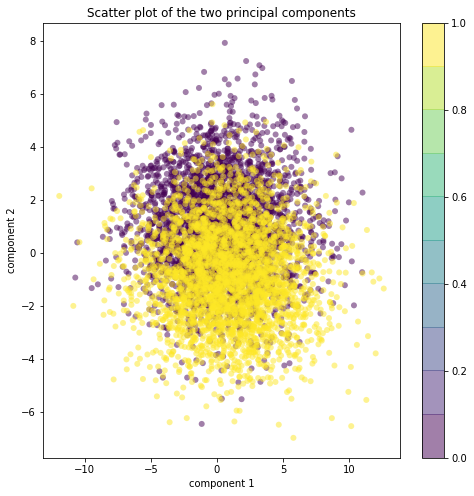

In [51]:
import matplotlib.cm as cm

plot_num = 3000
plot_range = (int(data_ana.shape[0]/2-plot_num),int(data_ana.shape[0]/2+plot_num))
print(plot_range)

plt.figure(figsize=(8,8))
plt.scatter(projected[plot_range[0]:plot_range[1], 0], projected[plot_range[0]:plot_range[1], 1],
            c=data_tar[plot_range[0]:plot_range[1]], edgecolor='none', alpha=0.5,
            cmap=cm.get_cmap('viridis', 10))
plt.title("Scatter plot of the two principal components")
plt.xlabel('component 1')
plt.ylabel('component 2')
#plt.xlim(-60,150)
#plt.ylim(-60,60)
plt.colorbar();


**Figure 3.** The combination of two PCA components is not linearly separable; thus, it is not a good method to classify the spectra.

Text(0.5, 1.0, 'PCA explained variance')

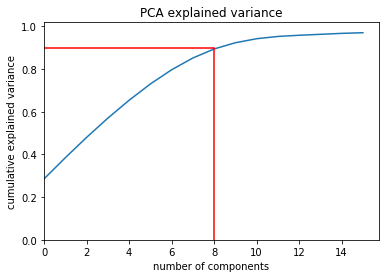

In [52]:
# visualize Cumulative explained variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.plot([0,8],[0.9,0.9], color="red")
plt.plot([8,8],[0,np.cumsum(pca.explained_variance_ratio_)[8]], color="red")
plt.xlim(0)
plt.ylim(0)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title("PCA explained variance")

**Figure 4.** Cumulative explained variance measures the proportion of variances that is counted for by the trained PCA model.

##### Train Support Vector Classification - PCA+SVC (code) 

In [57]:
# manual test-train split
X = projected
y = data_tar
setrange = (int(y.shape[0]/2-40000),int(y.shape[0]/2+40000))

testx = np.concatenate([X[:setrange[0]],X[setrange[1]:]])
testy = np.concatenate([y[:setrange[0]],y[setrange[1]:]])
trainx = X[setrange[0]:setrange[1]]
trainy = y[setrange[0]:setrange[1]]

In [58]:
# setup and train Support Vector Machine
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
model = SVC()
model.fit(trainx, trainy)

/opt/anaconda/2019.07/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [59]:
# make prediction and generate confusion matrix
predictions = model.predict(testx)
cm = confusion_matrix(testy,predictions)

Text(0.5, 1, 'PCA Confusion Matrix')

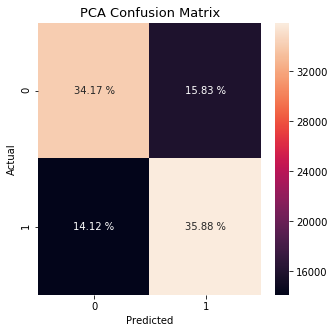

In [60]:
# visualize PCA+SVC confusion matrix
import seaborn as sn
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (5,5))
ax = sn.heatmap(df_cm, annot=True, fmt='.1f')
for t in ax.texts: t.set_text(str(round(int(float(t.get_text()))/predictions.shape[0]*100, 2)) + " %")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title("PCA+SVC Confusion Matrix", fontsize=13)

**Figure 5.** Confusion matrix of the prediction with PCA+SVC model

#### (a.1.2) t-Distributed Stochastic Neighbor Embedding - t-SNE (text)(code)
While PCA looks at the variance of the entire dataspace, t-SNE looks at the local variances in the manifold. In other words, t-SNE explores how the data is arranged in a high-dimensional space **[7]**. The prediction accuracy using t-SNE with PCA proved to be worse than that with PCA. It must also be noted that with the same amount of training dataset, t-SNE took significantly more time to both train and predict. In the real-time operation, t-SNE will not be applicable for in-situ analysis.


In [61]:
import time
from sklearn.manifold import TSNE
time_start = time.time()
tsne = TSNE(n_components=3, verbose=True, perplexity=50, n_iter=10000)
tsne_results = tsne.fit_transform(data_ana[plot_range[0]:plot_range[1]])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
tsne_results.shape

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 6000 samples in 0.008s...
[t-SNE] Computed neighbors for 6000 samples in 3.998s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6000
[t-SNE] Computed conditional probabilities for sample 2000 / 6000
[t-SNE] Computed conditional probabilities for sample 3000 / 6000
[t-SNE] Computed conditional probabilities for sample 4000 / 6000
[t-SNE] Computed conditional probabilities for sample 5000 / 6000
[t-SNE] Computed conditional probabilities for sample 6000 / 6000
[t-SNE] Mean sigma: 1.735214
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.860626
[t-SNE] KL divergence after 1050 iterations: 2.522856
t-SNE done! Time elapsed: 293.699960231781 seconds


(6000, 3)

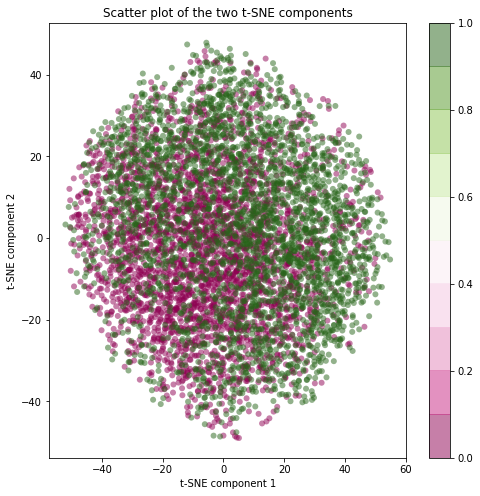

In [62]:
# visualize t-SNE 2-component scatter plot 
import matplotlib.cm as cm

plt.figure(figsize=(8,8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
            c=data_tar[plot_range[0]:plot_range[1]], edgecolor='none', alpha=0.5,
            cmap=cm.get_cmap('PiYG', 10))
plt.title("Scatter plot of the two t-SNE components")
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.colorbar();

##### Train Support Vector Classification - tSNE+SVC (code) 

In [255]:
# manual test-train split
targett2 = data_tar[plot_range[0]:plot_range[1]]
X2 = tsne_results
y2 = targett2
setrange2 = (int(y2.shape[0]/2-1000),int(y2.shape[0]/2+1000))  # (2000,4000)

testx2 = np.concatenate([X2[:setrange2[0]],X2[setrange2[1]:]])
testy2 = np.concatenate([y2[:setrange2[0]],y2[setrange2[1]:]])
trainx2 = X2[setrange2[0]:setrange2[1]]
trainy2 = y2[setrange2[0]:setrange2[1]]

In [256]:
# setup and train Support Vector Machine
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
model2 = SVC()
model2.fit(trainx2, trainy2)

/opt/anaconda/2019.07/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [ ]:
# make prediction and generate confusion matrix
predictions2 = model2.predict(testx2)
cm2 = confusion_matrix(testy2,predictions2)

Text(0.5, 1, 't-SNE Confusion Matrix')

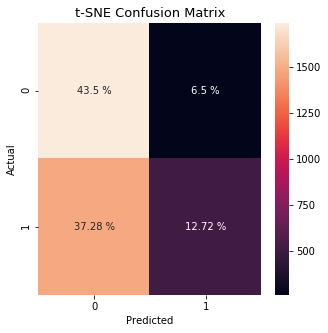

In [257]:
# visualize tSNE+SVC confusion matrix
import seaborn as sn
df_cm2 = pd.DataFrame(cm2)
plt.figure(figsize = (5,5))
ax = sn.heatmap(df_cm2, annot=True, fmt='.1f')
for t in ax.texts: 
    t.set_text(str(round(int(float(t.get_text()))/predictions2.shape[0]*100, 2)) + " %")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title("t-SNE+SVC Confusion Matrix", fontsize=13)

**Figure 6.** Confusion matrix of prediction with t-SNE+SVC model

#### (a.1.3) Independent Component Analysis (ICA)
In contrast to the PCA, ICA does not choose components based on greatest variance but based on the strongest independent signals **[8]**. This technique assumes that every signal is the combination of various independent sources. With a 16-component ICA, the SVC model was able to achieve the accuracy of 69.93%, slightly slower than PCA+SVC.


In [277]:
# setup and fir ICA
numICAcomp = 16
ica = sklearn.decomposition.FastICA(n_components=numICAcomp, max_iter=2000, tol=0.01)
ICA = ica.fit_transform(data_ana)

In [288]:
# manual test-train split
X3 = ICA
y3 = data_tar
setrange = (int(y3.shape[0]/2-40000),int(y3.shape[0]/2+40000))

testx3 = np.concatenate([X3[:setrange[0]],X3[setrange[1]:]])
testy3 = np.concatenate([y3[:setrange[0]],y3[setrange[1]:]])
trainx3 = X3[setrange[0]:setrange[1]]
trainy3 = y3[setrange[0]:setrange[1]]

In [ ]:
# setup and train Support Vector Machine
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
model3 = SVC()
model3.fit(trainx3, trainy3)

In [290]:
# make prediction and generate confusion matrix
predictions4 = model4.predict(testx4)
cm4 = confusion_matrix(testy4,predictions4)

Text(0.5, 1, 'ICA Confusion Matrix')

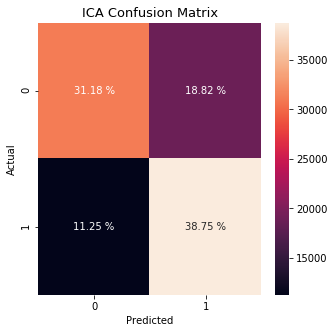

In [291]:
# visualize ICA+SVC confusion matrix
import seaborn as sn
df_cm = pd.DataFrame(cm4)
plt.figure(figsize = (5,5))
ax = sn.heatmap(df_cm, annot=True, fmt='.1f')
for t in ax.texts: t.set_text(str(round(int(float(t.get_text()))/predictions4.shape[0]*100, 2)) + " %")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title("ICA Confusion Matrix", fontsize=13)

**Figure 7.** Confusion matrix of the prediction with ICA+SVC model

#### (a.1.4) Non-negative matrix factorization- NMF (text)(code)
<span style="color:red">TEXT NEEDED</span>

In [260]:
# Setup and fit NMF
numNMFcomp=4
NMFcomponents = list()
NMFembeddings = list()
for k in range(len(data_comb_o)):
    arrayx = np.array(data_comb_o[k])
    dim = arrayx.shape
    arrayx = arrayx.reshape((-1,dim[2]))
   
    # setup NMF 
    NMFmodel = sklearn.decomposition.NMF(n_components=numNMFcomp, 
                                     init='random',
                                     random_state=0, 
                                     alpha=1e-7, 
                                     l1_ratio=1)

    # computes NMF
    data_for_nmf = arrayx.reshape((-1,dim[2]))
    comp = NMFmodel.fit_transform(np.rollaxis(data_for_nmf - np.min(data_for_nmf), 1))
    comp = np.swapaxes(comp,0,1)

    emb = np.rollaxis(NMFmodel.components_, 1)
    emb = emb.reshape((dim[0],dim[1],numNMFcomp))
     
    NMFembeddings.append(emb)
    NMFcomponents.append(comp)
# convert to np array
NMFembeddings = np.array(NMFembeddings)
NMFcomponents = np.array(NMFcomponents)

NMFembeddings.shape
NMFcomponents.shape

In [267]:
# manual test-train split
X4 = ??
y4 = data_tar??
setrange = (int(y4.shape[0]/2-40000),int(y4.shape[0]/2+40000))

testx4 = np.concatenate([X4[:setrange[0]],X4[setrange[1]:]])
testy4 = np.concatenate([y4[:setrange[0]],y4[setrange[1]:]])
trainx4 = X4[setrange[0]:setrange[1]]
trainy4 = y4[setrange[0]:setrange[1]]

In [ ]:
# setup and train Support Vector Machine
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.svm import SVC
model4 = SVC()
model4.fit(trainx4, trainy4)

In [ ]:
# make prediction and generate confusion matrix
predictions4 = model.predict(testx4)
cm4 = confusion_matrix(testy4,predictions4)

In [ ]:
# visualize ICA+SVC confusion matrix
import seaborn as sn
df_cm = pd.DataFrame(cm3)
plt.figure(figsize = (5,5))
ax = sn.heatmap(df_cm, annot=True, fmt='.1f')
for t in ax.texts: t.set_text(str(round(int(float(t.get_text()))/predictions.shape[0]*100, 2)) + " %")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title("NMF Confusion Matrix", fontsize=13)

**Figure 7.** Confusion matrix of the prediction with NMF+SVC model

### (a.2) Convolutional Neural Network (CNN)
Another approach to classifying spectra is by the use of one-dimensional CNN. 1-D CNN works as a biased filter which finds a set of sequential patterns that are most prominent across all spectra. The model consisted of two 1D convolutional layers, max pooling, and two fully connected layers with rectified linear units (ReLu) as activating functions. This resulted in 86% prediction accuracy as shown in **figure 8**. This is considered much better accuracy compared to other SVC combinations.


In [10]:
input_shape = (300, 30, 3170) # shape of input (px_row, px_column, energy_channels)
num_classes = 2 # number of possible states, so anneal and not anneal

In [387]:
# setting up CNN model: relu + not deep but somehow can reach 70%+ accuracy within 1 epoch
model_CNN = Sequential([
                        Conv1D(filters=128, kernel_size=9, activation='relu', input_shape=(N_steps,1)),
                        Conv1D(filters=128, kernel_size=9, activation='relu'),
                        Dropout(0.2),
                        MaxPooling1D(pool_size=2),
                        Flatten(),
                        Dense(100, activation='relu'),
                        Dense(2, activation='softmax') 
                    ])
import datetime
model_A.save('cnn_supervised_A_'+str(datetime.date.today())+"_"+str(datetime.time())+'.model')

In [ ]:
# pre-trained CNN network 
model_CNN.load_weights("rnn_auto_checkpoints/weights.25-0.09173137.hdf5")

In [463]:
# compile model
lr = 2e-3
model_CNN.compile(loss='categorical_crossentropy', optimizer=SGD(lr), metrics=['accuracy']) # categorical loss, SGD

In [ ]:
# Prediction
y_predict_raw = model_CNN.predict(x_validate, verbose=1)

In [ ]:
y_predict = list()
y_true = list()
for i in y_predict_raw:
    y_predict.append(list(i).index(max(i)))
for i in y_validate:
    y_true.append(list(i).index(max(i)))
y_predict = np.array(y_predict)
y_true = np.array(y_true)

Text(0.5, 1, 'CNN Confusion Matrix')

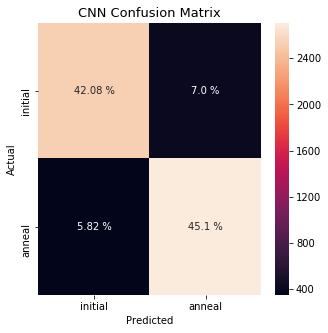

In [9]:
df_cm = pd.DataFrame([[2525,420],[349,2706]], 
                     index = ["initial","anneal"],
                     columns = ["initial","anneal"])
plt.figure(figsize = (5,5))
ax = sn.heatmap(df_cm, annot=True, fmt='.1f')
for t in ax.texts: t.set_text(str(round(int(float(t.get_text()))/6000*100, 2)) + " %")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title("CNN Confusion Matrix", fontsize=13)

**Figure 8.** Confusion matrix of the prediction using CNN model.

## Borrowed from the RNN Autoencoder code

In [ ]:
arrayx = data_ana
array_target = data_tar

In [ ]:
arrayx.shape

In [ ]:
array_target.shape

### Setting up RNN autoencoder

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, LeakyReLU
from keras.models import Sequential, Input, Model
from keras.layers import (Dense, Conv1D, Conv2D, GRU, LSTM, Recurrent, Bidirectional, TimeDistributed,
                          Dropout, Flatten, RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
from keras.layers.core import Lambda
from keras.optimizers import Adam
from keras.regularizers import l1

In [ ]:
def rnn_autoencoder(layer, size, N_encode, 
                    N_decode, embed, 
                    N_steps, lr = 3e-6, drop_frac = 0.1,
                    bidir = False, l1_norm = 1e-4, **kwargs):
    """
    Function which builds the reccurrent neural network autoencoder
    
    Parameters
    ----------
    layer : string; options: 'lstm','gru'
        selects the layer type
    size  : numpy, int
        sets the size of encoding and decoding layers in the network
    N_encode  : numpy, int
        sets the number of encoding layers in the network
    N_decode : numpy, int
        sets the number of decoding layers in the network
    embed : numpy, int
        sets the size of the embedding layer
    N_steps : numpy, int
        length of the input time series
    lr : numpy, float
        sets the learning rate for the model
    drop_frac : numpy, float
        sets the dropout fraction
    bidir : numpy, bool
        selects if the model is linear or bidirectional
    l1_norm : numpy. float
        sets the lambda value of the l1 normalization. The larger the value the greater the
        sparsity. None can be passed to exclude the use or l1 normailzation.
    
    Returns
    -------
    model : Keras, object
        Keras tensorflow model
    """

    model = Sequential()
    
    
    
    # wrapper for bidirectional LSTM
    if bidir: wrapper = Bidirectional
    else: wrapper = lambda x: x
        
        
    # builds the first layer
    model.add(wrapper(layer(size, return_sequences=(N_encode > 1),  dropout=drop_frac, input_shape=(N_steps, 1))))

    # builds the encoding layers
    for i in range(1, N_encode):
        model.add(wrapper(layer(size, return_sequences=(i < N_encode - 1), dropout=drop_frac)))

    # builds the embedding layer
    model.add(Dense(embed, activation='relu', name='encoding', activity_regularizer=l1(l1_norm)))

    # builds the repeat vector
    model.add(RepeatVector(N_steps))

    # builds the decoding layer
    for i in range(N_decode):
        model.add(wrapper(layer(size, return_sequences=True, dropout=drop_frac)))

    # builds the time distributed layer to reconstruct the original input
    model.add(TimeDistributed(Dense(1, activation='linear')))

    # complies the model
    model.compile(Adam(lr), loss='mse')

    # returns the model
    return model

In [ ]:
def train_model(model, data_train, data_test, path, epochs, batch_size):
    """
    Function which trains the neural network
    
    Parameters
    ----------
    model : Keras, object
        model to train
    data_train  : numpy, float
        data to train the network
    data_test  : numpy, float
        data to test the network
    path : string
        sets the folder to save the data
    epochs : numpy, int
        train the network for this number of epochs
    batch_size : numpy, int
        sets the size of the batch. Batch size should be as large as possible. 
        It is however limited by the GPU memory.
    """

    #builds the filename
    filepath = path + '/weights.{epoch:02d}-{val_loss:.8f}.hdf5'
    
    # sets the control of checkpoints
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', 
                                                 verbose=0, save_best_only=True,
                                                 save_weights_only=True, 
                                                 mode='min', period=1)

    # fits the model
    model.fit(np.atleast_3d(data_train), np.atleast_3d(data_train), 
              epochs=epochs, batch_size=batch_size, callbacks=[checkpoint], 
              validation_data=(np.atleast_3d(data_test), np.atleast_3d(data_test)))

In [ ]:
# construct a model
model3 = rnn_autoencoder(LSTM, 81, 3, 3, 9, 81)

In [ ]:
model3.summary()

### Training RNN Autoencoder

In [ ]:
# set learning rate and compile model
lr = 1e-5
model3.compile(Adam(lr), loss='mse')
folder_name = 'rnn_auto_deep2_checkpoints'

## Load model

In [ ]:
# load weights
model3.load_weights(folder_name+"/weights.99-0.10366738.hdf5")

# Compile model (required to make predictions)
lr = 5e-3
model3.compile(Adam(lr), loss='mse')

## Make Prediction

In [ ]:
test = arrayx[:]
test.shape

In [ ]:
predict = model3.predict(np.atleast_3d(test))

In [ ]:
predict.shape

In [ ]:
from sklearn import preprocessing
y1_norm = preprocessing.normalize(test)
y2_norm = preprocessing.normalize(predict.reshape(-1,81))
#y1_norm = test
#y2_norm = predict.reshape(-1,81)

In [ ]:
# Plotting Spectra Predictions (randomized for 36 spectra)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs.reshape(-1)
for i in range (0,2):
    for j in range(0,2):
        w = np.random.randint(0, y2_norm.shape[0])
        ax = axs[i,j]
        ax.plot(y1_norm[w], label="raw spectrum") 
        ax.plot(y2_norm[w], label="predict spectrum") 
        ax.legend(bbox_transform=ax.transAxes)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle("Spectra Prediction - RNN Autoencoder (LSTM, 81, 3, 3, 9, 81)"\
             "\n Labeled EELS data (anneal)", fontsize =18)

In [ ]:
def get_ith_layer_output(model, X, i, mode='test'):
    """
    Computes the activations of a specific layer
    see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'
    
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
        
    Returns
    -------
    layer_output : float
        array containing the output from layer i of the network
    """
    # computes the output of the ith layer
    get_ith_layer = backend.function([model.layers[0].input, 
                                            backend.learning_phase()], 
                                           [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode == 'test' else 1])[0]

    return layer_output

In [ ]:
activation = get_ith_layer_output(model3, np.atleast_3d(test), 3)

In [ ]:
activation.shape

In [ ]:
actv = activation.reshape(int(test.shape[0]/(20*300)),20,300,9)
fig, axs = plt.subplots(9, 1, figsize=(10, 10))
for k in range(9):
    ax = axs[k]
    ax.imshow(actv[0,:,:,k], cmap='viridis', interpolation='bilinear')
    #ax.pcolor(actv[0,:,:,k], cmap='viridis')
    ax.set_title(str(k+1), fontsize=28, color='white', loc='left', y=0.1, x=0.01)
fig.suptitle("Low dimensional Layer - RNN Autoencoder (LSTM, 81, 3, 3, 9, 81)"\
             " \n Labeled EELS data (initial)", fontsize=18)
plt.subplots_adjust(top=2.25)
plt.tight_layout()

In [ ]:
actv = activation.reshape(int(test.shape[0]/(20*300)),20,300,9)
fig, axs = plt.subplots(9, 1, figsize=(10, 10))
for k in range(9):
    ax = axs[k]
    ax.imshow(actv[3,:,:,k], cmap='viridis', interpolation='bilinear')
    #ax.pcolor(actv[3,:,:,k], cmap='viridis')
    ax.set_title(str(k+1), fontsize=28, color='white', loc='left', y=0.1, x=0.01)
fig.suptitle("Low dimensional Layer - RNN Autoencoder (LSTM, 81, 3, 3, 9, 81)"\
             " \n Labeled EELS data (anneal)", fontsize=18)
plt.subplots_adjust(top=2.25)
plt.tight_layout()

In [ ]:
# visualizing activation layer

import math

start = 387.5 #eV
stop = 851.25 #eV
step = 0.125 #eV

# Plotting aggregared spectra 
g,(ax3) = plt.subplots(1,1, figsize=(10,10))
for k in range(len(actv)):
    # Plotting aggregation over oxygen range
    ax3.plot(np.sum(actv[k][5:15,150:170], axis=(0,1)), color=(0.5*k/len(actv), 0.2*k/len(actv), 0.3*k/len(actv)), label="les")
    ax3.legend()
# plot configurations
g.suptitle('Pixel aggregation', fontsize=28)

ax3.set_title('Over O Peaks', fontsize=18)
ax3.set_xlabel('Energy Loss (eV)', fontsize=18)
ax3.set_ylabel('counts', fontsize=18)   

ax4.set_title('Over Fe Peaks', fontsize=18)
ax4.set_xlabel('Energy Loss (eV)', fontsize=18)
ax4.set_ylabel('counts', fontsize=18)  

In [ ]:
activation.shape

In [ ]:
import sklearn 
pca = sklearn.decomposition.PCA(9)  # project from N_resampled to 2 dimensions
projected = pca.fit_transform(activation)

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [ ]:
import matplotlib.cm as cm

plot_num = 5000
plot_range = (int(activation.shape[0]/2-plot_num),int(activation.shape[0]/2+plot_num))

plt.figure(figsize=(8,8))
plt.scatter(projected[plot_range[0]:plot_range[1], 0], projected[plot_range[0]:plot_range[1], 1],
            c=array_target.reshape((-1))[plot_range[0]:plot_range[1]], edgecolor='none', alpha=0.5,
            cmap=cm.get_cmap('viridis', 10))
plt.title("Scatter plot of the two principal components")
plt.xlabel('component 1')
plt.ylabel('component 2')
#plt.xlim(-60,150)
#plt.ylim(-60,60)
plt.colorbar();
